### XGBoost Predictive Analysis

In [1]:
%pip install pandas
%pip install yfinance
%pip install scikit-learn
%pip install projectpro
%pip install plotly
%pip install --upgrade nbformat

Note: you may need to restart the kernel to use updated packages.
^C
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

import yfinance as yf

import keras
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns
import os 
import math

import plotly.express as px

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score

from keras.layers import LSTM, SimpleRNN
from keras.models import Sequential
from keras.layers import Dense

from xgboost import XGBRegressor

from itertools import cycle

from projectpro import model_snapshot, checkpoint

In [ ]:
keras.backend.set_image_data_format("channels_last")
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
yf.pdr_override()
%matplotlib inline

In [ ]:
now = datetime.now() 
dataset = yf.download('NVDA', now - relativedelta(years=4), now)
print(dataset.head())

[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2020-02-24  67.547501  70.467499  67.000000  68.320000  68.054062   85691600
2020-02-25  69.074997  69.697502  64.489998  65.512497  65.257500  105549600
2020-02-26  65.514999  68.862503  65.500000  66.912498  66.652054   74773200
2020-02-27  63.724998  66.750000  62.222500  63.150002  62.941822   90641600
2020-02-28  60.615002  68.114998  60.447498  67.517502  67.294922  113325200


In [ ]:
print(f"Shape of data: {dataset.shape}")

print("Starting date: ",dataset.iloc[0][0])
print("Ending date: ", dataset.iloc[-1][0])
print("Duration: ", dataset.iloc[-1][0]-dataset.iloc[0][0])

print(dataset.columns)
dataset = dataset.reset_index()
print(dataset.columns)

Shape of data: (1007, 6)
Starting date:  67.54750061035156
Ending date:  750.25
Duration:  682.7024993896484
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


In [ ]:
closedf = dataset[['Date','Close']]
closedf = closedf[closedf['Date'] > '2018-09-13']
close_stock = closedf.copy()
del closedf['Date']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))

print(closedf.shape)

(1007, 1)


In [ ]:
training_size=int(len(closedf))-14
# training_size=int(len(closedf)*0.7)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (993, 1)
test_data:  (14, 1)


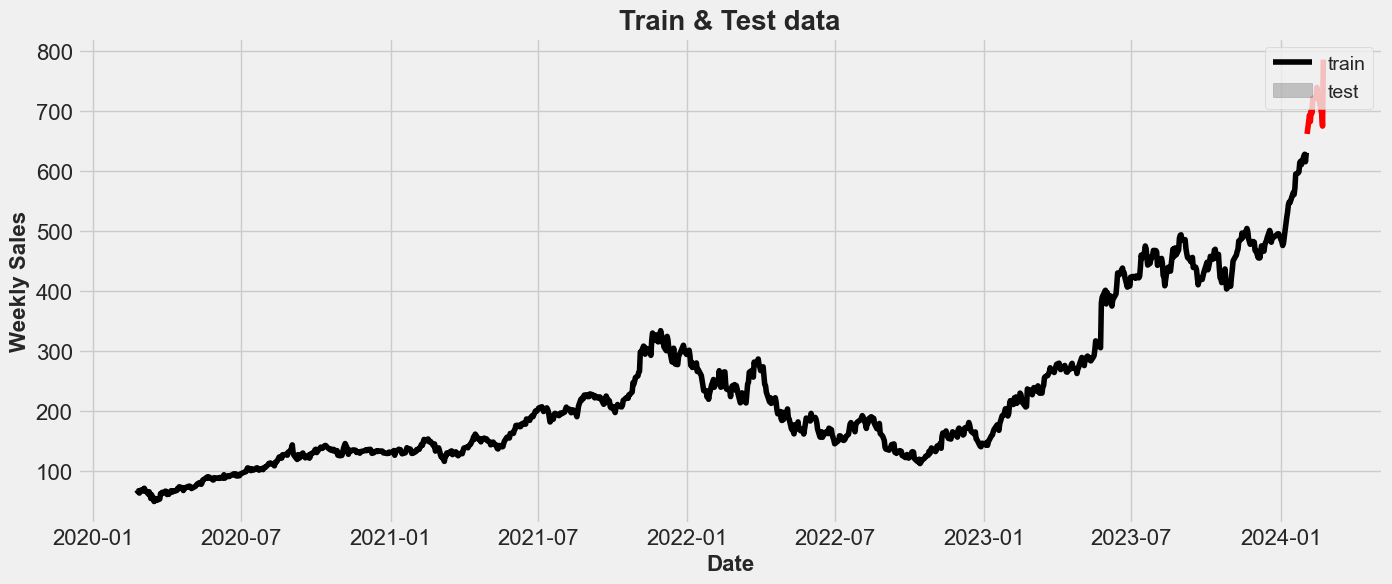

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x = close_stock['Date'][:training_size], y = close_stock['Close'][:training_size], color = 'black')
sns.lineplot(x = close_stock['Date'][training_size:], y = close_stock['Close'][training_size:], color = 'red')

# Formatting
ax.set_title('Train & Test data', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Weekly Sales', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)
plt.legend(loc='upper right' ,labels = ('train', 'test'))
plt.show()

In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
time_step = 1
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)


X_train:  (991, 1)
y_train:  (991,)
X_test:  (12, 1)
y_test (12,)


In [ ]:
my_model = XGBRegressor(n_estimators=1000)
my_model.fit(X_train, y_train, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Testing data set 1-day at a time WITHOUT re-training model

In [ ]:
total_MAS = 0
total_RMSE = 0
for i in range(1,12):
    predictions = my_model.predict([X_test[i]])
    Mas = mean_absolute_error([y_test[i]], predictions)
    Rmse = math.sqrt(mean_squared_error([y_test[i]], predictions))
    print(f"Day {i} Mean Absolute Error - MAE : {str(Mas)}, Root Mean squared Error - RMSE : {str(Rmse)}")
    total_MAS += Mas
    total_RMSE += Rmse
print(f"Total MAS: {total_MAS} and Total RMSW: {total_RMSE}");

Day 1 Mean Absolute Error - MAE : 0.08650225059163275, Root Mean squared Error - RMSE : 0.08650225059163275
Day 2 Mean Absolute Error - MAE : 0.11198170080396375, Root Mean squared Error - RMSE : 0.11198170080396375
Day 3 Mean Absolute Error - MAE : 0.10576121803928384, Root Mean squared Error - RMSE : 0.10576121803928384
Day 4 Mean Absolute Error - MAE : 0.13960709695546336, Root Mean squared Error - RMSE : 0.13960709695546336
Day 5 Mean Absolute Error - MAE : 0.14116895300057775, Root Mean squared Error - RMSE : 0.14116895300057775
Day 6 Mean Absolute Error - MAE : 0.1395392045877043, Root Mean squared Error - RMSE : 0.1395392045877043
Day 7 Mean Absolute Error - MAE : 0.16360609564665973, Root Mean squared Error - RMSE : 0.16360609564665973
Day 8 Mean Absolute Error - MAE : 0.14673753640010834, Root Mean squared Error - RMSE : 0.14673753640010834
Day 9 Mean Absolute Error - MAE : 0.14612633929694885, Root Mean squared Error - RMSE : 0.14612633929694885
Day 10 Mean Absolute Error - M

Testing data set 1-day at a time WITH re-training model

In [ ]:
X_train_copy = X_train.copy()
y_train_copy = y_train.copy()



total_MAS = 0
total_RMSE = 0
for i in range(1,12):
    # Training model up to current day
    my_model = XGBRegressor(n_estimators=1000)
    my_model.fit(X_train_copy, y_train_copy, verbose=False)
    predictions = my_model.predict([X_test[i]])
    
    # Calculating error measures
    Mas = mean_absolute_error([y_test[i]], predictions)
    Rmse = math.sqrt(mean_squared_error([y_test[i]], predictions))
    print(f"Day {i} Mean Absolute Error - MAE : {str(Mas)}, Root Mean squared Error - RMSE : {str(Rmse)}")
    total_MAS += Mas
    total_RMSE += Rmse
    
    x_add = np.array(X_test[i])
    y_add = np.array(y_test[i])
    
    X_train_copy = np.concatenate((X_train_copy, [x_add]), axis=0)
    y_train_copy = np.concatenate((y_train_copy, [y_add]), axis=0)
    
    
print(f"Total MAS: {total_MAS} and Total RMSE: {total_RMSE}");

Day 1 Mean Absolute Error - MAE : 0.08650225059163275, Root Mean squared Error - RMSE : 0.08650225059163275
Day 2 Mean Absolute Error - MAE : 0.0964190472623988, Root Mean squared Error - RMSE : 0.0964190472623988
Day 3 Mean Absolute Error - MAE : 0.06709032055545816, Root Mean squared Error - RMSE : 0.06709032055545816
Day 4 Mean Absolute Error - MAE : 0.07755091314046092, Root Mean squared Error - RMSE : 0.07755091314046092
Day 5 Mean Absolute Error - MAE : 0.053690732537778674, Root Mean squared Error - RMSE : 0.053690732537778674
Day 6 Mean Absolute Error - MAE : 0.02294036005950606, Root Mean squared Error - RMSE : 0.02294036005950606
Day 7 Mean Absolute Error - MAE : 0.04156039986495197, Root Mean squared Error - RMSE : 0.04156039986495197
Day 8 Mean Absolute Error - MAE : 0.009233972042350769, Root Mean squared Error - RMSE : 0.009233972042350769
Day 9 Mean Absolute Error - MAE : 0.007224330763471065, Root Mean squared Error - RMSE : 0.007224330763471065
Day 10 Mean Absolute Err

In [ ]:
train_predict=my_model.predict(X_train)
test_predict=my_model.predict(X_test)

train_predict = train_predict.reshape(-1,1)
test_predict = test_predict.reshape(-1,1)

print("Train data prediction:", train_predict.shape)
print("Test data prediction:", test_predict.shape)

Train data prediction: (990, 1)
Test data prediction: (11, 1)


In [ ]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])

plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Close price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (1007, 1)
Test predicted data:  (1007, 1)


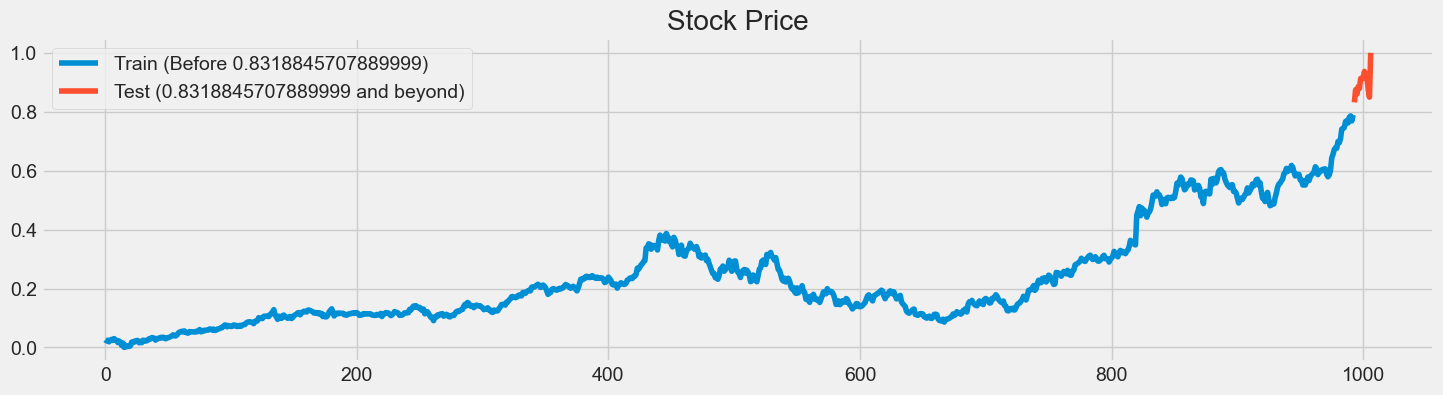

In [ ]:
def train_test_plot(train_set, test_set):
    plt.figure(figsize=(16, 4))
    plt.plot(train_set, label=f"Train (Before {test_set[0][0]})")
    plt.plot(range(len(train_set), len(train_set) + len(test_set)), test_set, label=f"Test ({test_set[0][0]} and beyond)")
    plt.legend()
    plt.title("Stock Price")
    plt.show()
    
train_test_plot(train_data, test_data)